### Here I am trying to understand austral summer windspeed distribution in the MO and ERA datasets, looking for:

- latitude of max wind, latitude of max speedup
- how these datasets compare to each other 

In [2]:
import xarray as xr
import glob
import numpy as np
import netCDF4 as nc
import warnings
warnings.filterwarnings('ignore')
from matplotlib import pyplot as plt
from cmocean import cm
import warnings
warnings.filterwarnings('ignore')

In [3]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [4]:
tmesh = xr.open_dataset('/gpfs/data/greenocean/software/resources/regrid/mesh_mask3_6.nc')
tmesh['csize'] = tmesh.tmask[0,0,:,:] * tmesh.e1t[0,:,:] * tmesh.e2t[0,:,:]

so_csize = (tmesh['csize'][0:37,:].values)
so_csize_broad = np.zeros([365*10, 37, 182])

for i in range(0,365*10):
    so_csize_broad[i,:,:] = so_csize

##### histogram example code:

https://github.com/SalishSeaCast/analysis_tereza/blob/master/notebooks/PI_CARBON_PAPER/MAIN_ANALYSIS/KEY_REBOOT/MF04_aragonite_saturation_PI6.ipynb

##### first make a histogram for one year's worth of data, summer winds, to test concept

In [5]:
days_in_month = np.array([31,28,31,30,31,30,31,31,30,31,30,31])
starts = np.zeros_like(days_in_month)
ends = np.zeros_like(starts)

for i in range(0,12):
    starts[i] = np.sum(days_in_month[0:i])
    ends[i] = np.sum(days_in_month[0:i+1])
    
# print(starts)
# print(ends)

In [6]:
### get out summer and winter SO windspeeds for a year
rdir = '/gpfs/data/greenocean/software/resources/MetProcessed/MET_forcing/'
i = 0
yrs = [1950]

## get vflx uflx and windspeed
ty = f'{rdir}/scen_1A/MetOffice_tauy_y{yrs[i]}.nc'
t2 = glob.glob(ty); w = nc.Dataset(t2[0])
vflx = (w['vflx'][:,0:50,:])
ty = f'{rdir}/scen_1A/MetOffice_taux_y{yrs[i]}.nc'
t2 = glob.glob(ty); w = nc.Dataset(t2[0])
uflx = (w['uflx'][:,0:50,:])
wspd = np.sqrt(vflx**2 + uflx**2)

sum_wspd = np.concatenate((wspd[334:365,:,:],wspd[0:59,:,:]), axis = 0)
win_wspd = wspd[151:243,:,:]


In [7]:
## broadcast weighting mesh
tmesh = xr.open_dataset('/gpfs/data/greenocean/software/resources/regrid/mesh_mask3_6.nc')
tmesh['csize'] = tmesh.tmask[0,0,:,:] * tmesh.e1t[0,:,:] * tmesh.e2t[0,:,:]

so_csize = (tmesh['csize'][0:37,:].values)
so_csize_broad = np.zeros([365*10, 37, 182])

for i in range(0,365*10):
    so_csize_broad[i,:,:] = so_csize

In [8]:
bounds = np.array([0,7,16,22,28,32,37,40,44,47,50])
starts = np.zeros([10]); ends = np.zeros([10])
print('making histograms of summer and winter wind speed for the following latitude bands:')
for i in range(0,len(bounds)-1):
    s= np.format_float_positional(tmesh['nav_lat'][bounds[i],0].values, precision=1)
    e= np.format_float_positional(tmesh['nav_lat'][bounds[i+1],0].values, precision=1)
    bs = bounds[i]
    be = bounds[i+1]
    print(f'band {i}, {(s)} to {e}, band {bs} to {be}')
    starts[i] = s
    ends[i] = e
     
print(starts)
print(ends)

making histograms of summer and winter wind speed for the following latitude bands:
band 0, -78.2 to -75., band 0 to 7
band 1, -75. to -69.5, band 7 to 16
band 2, -69.5 to -64.9, band 16 to 22
band 3, -64.9 to -59.3, band 22 to 28
band 4, -59.3 to -54.9, band 28 to 32
band 5, -54.9 to -48.8, band 32 to 37
band 6, -48.8 to -44.6, band 37 to 40
band 7, -44.6 to -38.7, band 40 to 44
band 8, -38.7 to -33.8, band 44 to 47
band 9, -33.8 to -28.7, band 47 to 50
[-78.2 -75.  -69.5 -64.9 -59.3 -54.9 -48.8 -44.6 -38.7 -33.8]
[-75.  -69.5 -64.9 -59.3 -54.9 -48.8 -44.6 -38.7 -33.8 -28.7]


In [8]:
#subset windspeed

hists = np.zeros([10,20])

for i in range(0,10):
    sum_wspd_t = sum_wspd[:,bounds[i]:bounds[i+1],:]
    shex = (np.shape(sum_wspd_t))
    csize_t = so_csize_broad[0:shex[0],0:shex[1],0:shex[2]]

    nbins = 20
    hist_met_vflx, bins = np.histogram(np.ravel(sum_wspd_t), bins=nbins,\
                                 range = [0, 20], weights=np.ravel(csize_t))

    bin_cent = bins + (bins[1]-bins[0])/2
    tot_count = np.sum(hist_met_vflx)
    binsback = bin_cent[0:nbins]
    histback = hist_met_vflx/tot_count
    hists[i,:] = histback


Text(0.5, 0.93, 'Histograms of windspeed distribution by latitude band, \n austral summer, year 1950')

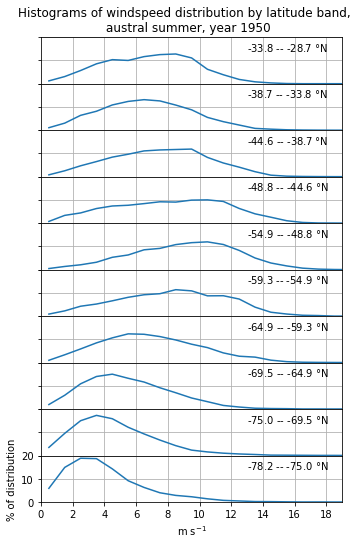

In [9]:
fact = 0.45
fig, axs = plt.subplots(10,1, figsize=(12*fact, 19*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()
fig.subplots_adjust(wspace=0, hspace=0)
for i in range(0,10):
    pos = 9-i
    axs[i].plot(binsback,hists[pos,:]*100)

    axs[i].set_ylim([0,20])
    axs[i].set_xlim([0,19])
    axs[i].set_yticks([0,10,20])
    axs[i].set_xticks(np.arange(0,20,2))
    axs[i].grid()
    if i!= 9:
        axs[i].set_xticks(np.arange(2,20,2))
        axs[i].set_yticks([0,10,20], color = 'w')
        axs[i].set_yticklabels([0,10,20], color = 'w')
    axs[i].text(13,14,f'{starts[pos]} -- {ends[pos]} $\degree$N')
    axs[9].set_ylabel('% of distribution')
    axs[9].set_xlabel('m s$^{-1}$')

plt.suptitle('Histograms of windspeed distribution by latitude band, \n austral summer, year 1950', y =.93)

#### now iteratively do this for multiple decades - just summer, just MET_1A for now

In [10]:
def decade_summers(yearst):

    yrs = np.arange(yearst,yearst+10,1)
    ## get vflx uflx and windspeed
    
    sumstor = np.zeros([90*10,50,182])
    ind = 0
    for i in range(0,10):
        ty = f'{rdir}/scen_1A/MetOffice_tauy_y{yrs[i]}.nc'
        t2 = glob.glob(ty); w = nc.Dataset(t2[0])
        vflx = (w['vflx'][:,0:50,:])
        ty = f'{rdir}/scen_1A/MetOffice_taux_y{yrs[i]}.nc'
        t2 = glob.glob(ty); w = nc.Dataset(t2[0])
        uflx = (w['uflx'][:,0:50,:])
        wspd = np.sqrt(vflx**2 + uflx**2)

        sum_wspd = np.concatenate((wspd[334:365,:,:],wspd[0:59,:,:]), axis = 0)
        sumstor[ind:ind+90,:,:] = sum_wspd
        ind = ind+90
    return sumstor

sum_50s = decade_summers(1950)


In [11]:
def get_hists(windvals):
    hists = np.zeros([10,20])

    for i in range(0,10):
        sum_wspd_t = windvals[:,bounds[i]:bounds[i+1],:]
        shex = (np.shape(sum_wspd_t))
        csize_t = so_csize_broad[0:shex[0],0:shex[1],0:shex[2]]

        nbins = 20
        hist_met_vflx, bins = np.histogram(np.ravel(sum_wspd_t), bins=nbins,\
                                     range = [0, 20], weights=np.ravel(csize_t))

        bin_cent = bins + (bins[1]-bins[0])/2
        tot_count = np.sum(hist_met_vflx)
        binsback = bin_cent[0:nbins]
        histback = hist_met_vflx/tot_count
        hists[i,:] = histback
        
    return binsback, hists


In [12]:
sum_50s = decade_summers(1950)
binsback, hists_50s = get_hists(sum_50s)

sum_60s = decade_summers(1960)
binsback, hists_60s = get_hists(sum_60s)

sum_70s = decade_summers(1970)
binsback, hists_70s = get_hists(sum_70s)

sum_80s = decade_summers(1980)
binsback, hists_80s = get_hists(sum_80s)

sum_90s = decade_summers(1990)
binsback, hists_90s = get_hists(sum_90s)

sum_00s = decade_summers(2000)
binsback, hists_00s = get_hists(sum_00s)

sum_10s = decade_summers(2010)
binsback, hists_10s = get_hists(sum_10s)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0.93, 'Histograms of austral summer windspeed distribution by latitude band \n Met Office historically accurate scenario')

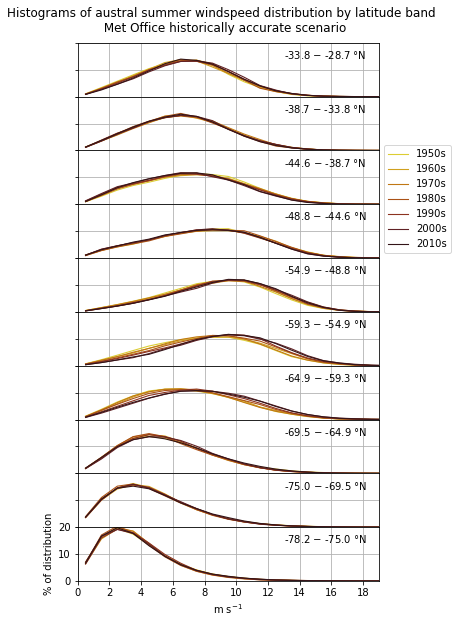

In [13]:
fact = 0.45
fig, axs = plt.subplots(10,1, figsize=(12*fact, 22*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()
fig.subplots_adjust(wspace=0, hspace=0)

tcm = cm.solar_r; seg = 7
for i in range(0,10):
    pos = 9-i; lw = 1.1
    axs[i].plot(binsback,hists_50s[pos,:]*100, color = tcm(1.*(1)/7), linewidth = lw, label = '1950s')
    axs[i].plot(binsback,hists_60s[pos,:]*100, color = tcm(1.*(2)/7), linewidth = lw, label = '1960s')
    axs[i].plot(binsback,hists_70s[pos,:]*100, color = tcm(1.*(3)/7), linewidth = lw, label = '1970s')
    axs[i].plot(binsback,hists_80s[pos,:]*100, color = tcm(1.*(4)/7), linewidth = lw, label = '1980s')
    axs[i].plot(binsback,hists_90s[pos,:]*100, color = tcm(1.*(5)/7), linewidth = lw, label = '1990s')
    axs[i].plot(binsback,hists_00s[pos,:]*100, color = tcm(1.*(6)/7), linewidth = lw, label = '2000s')
    axs[i].plot(binsback,hists_10s[pos,:]*100, color = tcm(1.*(7)/7), linewidth = lw, label = '2010s')

    axs[i].set_ylim([0,20])
    axs[i].set_xlim([0,19])
    axs[i].set_yticks([0,10,20])
    axs[i].set_xticks(np.arange(0,20,2))
    axs[i].grid()
    if i!= 9:
        axs[i].set_xticks(np.arange(2,20,2))
        axs[i].set_yticks([0,10,20], color = 'w')
        axs[i].set_yticklabels([0,10,20], color = 'w')
    axs[i].text(13,14,f'{starts[pos]} $-$ {ends[pos]} $\degree$N')
    axs[9].set_ylabel('% of distribution')
    axs[9].set_xlabel('m s$^{-1}$')
    axs[4].legend(bbox_to_anchor = [1, 1])

plt.suptitle('Histograms of austral summer windspeed distribution by latitude band \n Met Office historically accurate scenario', y =.93)

In [14]:
def decade_ERAsummers(yearst):

    yrs = np.arange(yearst,yearst+10,1)
    ## get vflx uflx and windspeed
    
    sumstor = np.zeros([90*10,50,182])
    ind = 0
    for i in range(0,10):
        typ = 'tauy'
        ty = f'/gpfs/data/greenocean/software/products/ERA5Forcing/daily/{typ}_1d_{yrs[i]}_daily.nc'
        t2 = glob.glob(ty); w = nc.Dataset(t2[0])
        vflx = (w['vflx'][:,0:50,:])
        typ = 'taux'
        ty = f'/gpfs/data/greenocean/software/products/ERA5Forcing/daily/{typ}_1d_{yrs[i]}_daily.nc'
        t2 = glob.glob(ty); w = nc.Dataset(t2[0])
        uflx = (w['uflx'][:,0:50,:])
        wspd = np.sqrt(vflx**2 + uflx**2)

        sum_wspd = np.concatenate((wspd[334:365,:,:],wspd[0:59,:,:]), axis = 0)
        sumstor[ind:ind+90,:,:] = sum_wspd
        ind = ind+90
    return sumstor

# sum_50s = decade_summers(1950)


In [15]:
ERAsum_50s = decade_ERAsummers(1950)
binsback, ERAhists50s = get_hists(ERAsum_50s)

ERAsum_60s = decade_ERAsummers(1960)
binsback, ERAhists60s = get_hists(ERAsum_60s)

ERAsum_70s = decade_ERAsummers(1970)
binsback, ERAhists70s = get_hists(ERAsum_70s)

ERAsum_80s = decade_ERAsummers(1980)
binsback, ERAhists80s = get_hists(ERAsum_80s)

ERAsum_90s = decade_ERAsummers(1990)
binsback, ERAhists90s = get_hists(ERAsum_90s)

ERAsum_00s = decade_ERAsummers(2000)
binsback, ERAhists00s = get_hists(ERAsum_00s)

ERAsum_10s = decade_ERAsummers(2010)
binsback, ERAhists10s = get_hists(ERAsum_10s)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0.93, 'Histograms of austral summer windspeed distribution by latitude band \n ERA5 reanalysis')

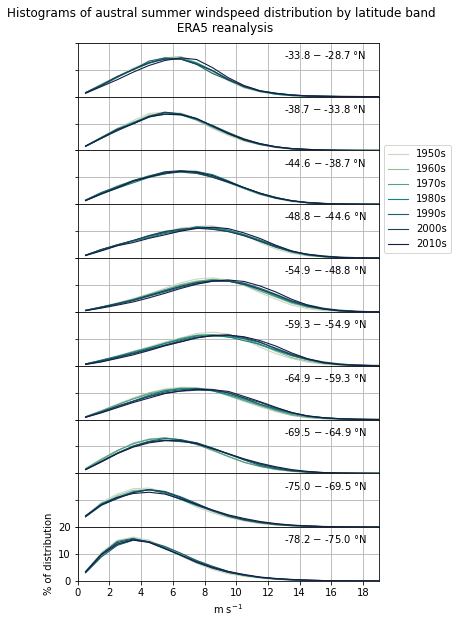

In [16]:
fact = 0.45
fig, axs = plt.subplots(10,1, figsize=(12*fact, 22*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()
fig.subplots_adjust(wspace=0, hspace=0)

tcm = cm.tempo; seg = 7
for i in range(0,10):
    pos = 9-i; lw = 1.1
    axs[i].plot(binsback,ERAhists50s[pos,:]*100, color = tcm(1.*(1)/7), linewidth = lw, label = '1950s')
    axs[i].plot(binsback,ERAhists60s[pos,:]*100, color = tcm(1.*(2)/7), linewidth = lw, label = '1960s')
    axs[i].plot(binsback,ERAhists70s[pos,:]*100, color = tcm(1.*(3)/7), linewidth = lw, label = '1970s')
    axs[i].plot(binsback,ERAhists80s[pos,:]*100, color = tcm(1.*(4)/7), linewidth = lw, label = '1980s')
    axs[i].plot(binsback,ERAhists90s[pos,:]*100, color = tcm(1.*(5)/7), linewidth = lw, label = '1990s')
    axs[i].plot(binsback,ERAhists00s[pos,:]*100, color = tcm(1.*(6)/7), linewidth = lw, label = '2000s')
    axs[i].plot(binsback,ERAhists10s[pos,:]*100, color = tcm(1.*(7)/7), linewidth = lw, label = '2010s')
    
    axs[i].set_ylim([0,20])
    axs[i].set_xlim([0,19])
    axs[i].set_yticks([0,10,20])
    axs[i].set_xticks(np.arange(0,20,2))
    axs[i].grid()
    if i!= 9:
        axs[i].set_xticks(np.arange(2,20,2))
        axs[i].set_yticks([0,10,20], color = 'w')
        axs[i].set_yticklabels([0,10,20], color = 'w')
    axs[i].text(13,14,f'{starts[pos]} $-$ {ends[pos]} $\degree$N')
    axs[9].set_ylabel('% of distribution')
    axs[9].set_xlabel('m s$^{-1}$')
    axs[4].legend(bbox_to_anchor = [1, 1])

plt.suptitle('Histograms of austral summer windspeed distribution by latitude band \n ERA5 reanalysis', y =.93)

### an attempt will now be made to plot both of these datasets at the same time. this will probably go badly

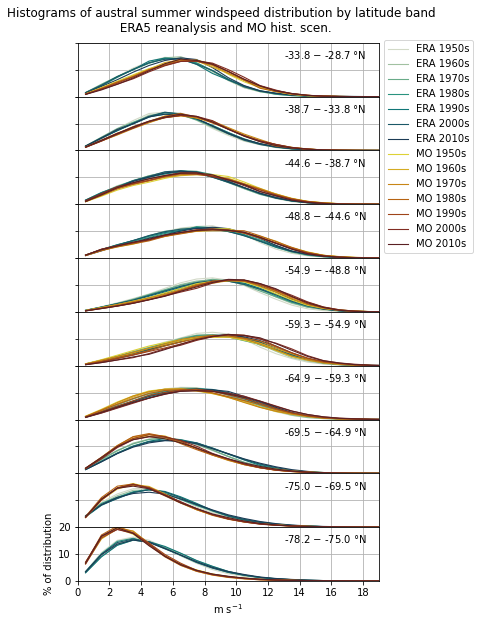

In [17]:
fact = 0.45
fig, axs = plt.subplots(10,1, figsize=(12*fact, 22*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()
fig.subplots_adjust(wspace=0, hspace=0)

tcm = cm.tempo; seg = 8
for i in range(0,10):
    pos = 9-i; lw = 1.1
    axs[i].plot(binsback,ERAhists50s[pos,:]*100, color = tcm(1.*(1)/seg), linewidth = lw, label = 'ERA 1950s')
    axs[i].plot(binsback,ERAhists60s[pos,:]*100, color = tcm(1.*(2)/seg), linewidth = lw, label = 'ERA 1960s')
    axs[i].plot(binsback,ERAhists70s[pos,:]*100, color = tcm(1.*(3)/seg), linewidth = lw, label = 'ERA 1970s')
    axs[i].plot(binsback,ERAhists80s[pos,:]*100, color = tcm(1.*(4)/seg), linewidth = lw, label = 'ERA 1980s')
    axs[i].plot(binsback,ERAhists90s[pos,:]*100, color = tcm(1.*(5)/seg), linewidth = lw, label = 'ERA 1990s')
    axs[i].plot(binsback,ERAhists00s[pos,:]*100, color = tcm(1.*(6)/seg), linewidth = lw, label = 'ERA 2000s')
    axs[i].plot(binsback,ERAhists10s[pos,:]*100, color = tcm(1.*(7)/seg), linewidth = lw, label = 'ERA 2010s')
tcm = cm.solar_r; seg = 8
for i in range(0,10):
    pos = 9-i; lw = 1.1
    axs[i].plot(binsback,hists_50s[pos,:]*100, color = tcm(1.*(1)/seg), linewidth = lw, label = 'MO 1950s')
    axs[i].plot(binsback,hists_60s[pos,:]*100, color = tcm(1.*(2)/seg), linewidth = lw, label = 'MO 1960s')
    axs[i].plot(binsback,hists_70s[pos,:]*100, color = tcm(1.*(3)/seg), linewidth = lw, label = 'MO 1970s')
    axs[i].plot(binsback,hists_80s[pos,:]*100, color = tcm(1.*(4)/seg), linewidth = lw, label = 'MO 1980s')
    axs[i].plot(binsback,hists_90s[pos,:]*100, color = tcm(1.*(5)/seg), linewidth = lw, label = 'MO 1990s')
    axs[i].plot(binsback,hists_00s[pos,:]*100, color = tcm(1.*(6)/seg), linewidth = lw, label = 'MO 2000s')
    axs[i].plot(binsback,hists_10s[pos,:]*100, color = tcm(1.*(7)/seg), linewidth = lw, label = 'MO 2010s')
    
    axs[i].set_ylim([0,20])
    axs[i].set_xlim([0,19])
    axs[i].set_yticks([0,10,20])
    axs[i].set_xticks(np.arange(0,20,2))
    axs[i].grid()
    if i!= 9:
        axs[i].set_xticks(np.arange(2,20,2))
        axs[i].set_yticks([0,10,20], color = 'w')
        axs[i].set_yticklabels([0,10,20], color = 'w')
    axs[i].text(13,14,f'{starts[pos]} $-$ {ends[pos]} $\degree$N')
    axs[9].set_ylabel('% of distribution')
    axs[9].set_xlabel('m s$^{-1}$')
    axs[4].legend(bbox_to_anchor = [1, 1])

plt.suptitle('Histograms of austral summer windspeed distribution by latitude band \n ERA5 reanalysis and MO hist. scen.', y =.93)

fig.savefig('/gpfs/home/mep22dku/scratch/SOZONE/uploadPics/lat_summer_winds_era_met.jpg')

In [18]:
print('done')

done


#### Obvious takeaways:

- ERA and MO agree best in midlatitudes -64 to - 55 say?
- MO underestimates winds in high latitudes (near land)? but overestimates in lower latitudes
- most obvious speedup in both datasets is in bands something like -65 to -50